In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
import holotomocupy.chunking as chunking
from holotomocupy.utils import *



astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 512  # object size in each dimension

noise = 0
z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

# ntheta = int(sys.argv[1])  # number of angles (rotations)
# noise = int(sys.argv[2])#sys.argv[2]=='True'
# z1c = float(sys.argv[3])  # positions of the code and the probe for reconstruction

center = n/2 # rotation axis
npos = 49  # number of code positions
detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = z1c
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = 1200+2*pad

show = True

flg = f'{n}_{1}_{npos}_{z1c}_{noise}_code'
path = f'/data2/vnikitin/nfp_codes'

## Read data

In [3]:
data00 = np.zeros([1, npos, n, n], dtype='float32')
ref0 = np.zeros([1, npos, n, n], dtype='float32')
print(f'{path}/data/data_{0}_{flg}.tiff')
for k in range(npos):
    data00[:, k] = read_tiff(f'{path}/data/data_{k}_{flg}.tiff')[:1]
for k in range(npos):
    ref0[:, k] = read_tiff(f'{path}/data/ref_{k}_{flg}.tiff')[:]
code = np.load(f'{path}/data/code_{flg}.npy')
shifts_code = np.load(f'{path}/data/shifts_code_{flg}.npy')[:, :npos]



/data2/vnikitin/nfp_codes/data/data_0_512_1_49_-0.0195_0_code.tiff


# Construct operators


In [4]:
def Lop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir
    return psi

def Lop2(prb):
    prb = cp.array(prb)
    psir = G(prb, wavelength, voxelsize, distances[0],'symmetric')
    data = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop2(data):
    data= cp.array(data)
    data = cp.pad(data, ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
    psi = GT(data, wavelength, voxelsize, distances[0],'symmetric')
    return psi

def Sop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
    
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
    return psi


data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = Sop(arr1)
arr3 = STop(arr2)

arr4 = Lop(arr2)
arr5 = LTop(arr4)

arr6 = Lop2(prb1)
arr7 = LTop2(arr6)


print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')
print(f'{cp.sum(prb1*cp.conj(arr7))}==\n{cp.sum(arr6*cp.conj(arr6))}')



(23553720+1.443875789642334j)==
(23553720-1.5848499596016197e-11j)
(15706361-0.1342606544494629j)==
(15706361+4.0612278098706156e-05j)
(262143.984375+3.3911492209881544e-05j)==
(262144+0j)


### Divide by reference image for 1step Paganin reconsturction

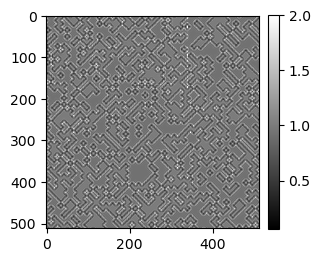

In [5]:
ref0 = cp.array(ref0)
data00 = cp.array(data00)

rdata = data00/ref0
mshow((rdata)[0,0],show,vmax=2)

/tmp/ipykernel_896165/3561898921.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
/tmp/ipykernel_896165/3561898921.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])


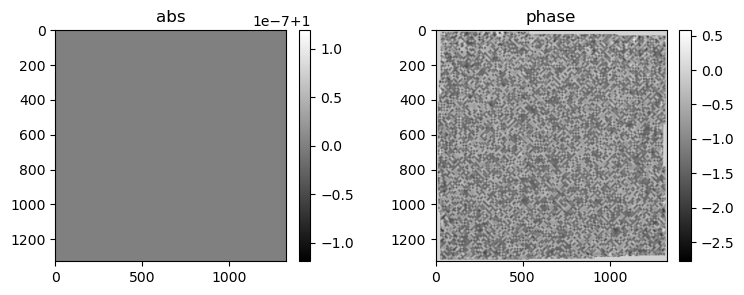

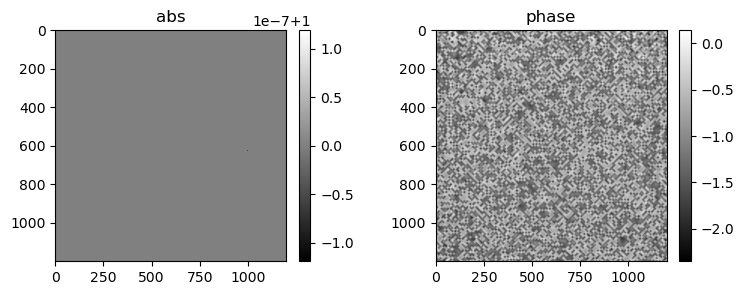

In [6]:
recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
for j in range(0,npos):
    r = multiPaganin(rdata[:,j:j+1],
                         distances[j:j+1], wavelength, voxelsize,  24.05, 5e-2)    
    rr = r*0+1 # to compensate for overlap
    r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
    recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])
    
recMultiPaganin = cp.sum(recMultiPaganin,axis=1)
recMultiPaganinr = cp.sum(recMultiPaganinr,axis=1)

# avoid division by 0
recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

# compensate for overlap
recMultiPaganin /= recMultiPaganinr
recMultiPaganin = cp.exp(1j*recMultiPaganin)

mshow_polar(recMultiPaganin[0],show)
mshow_polar(recMultiPaganin[0,pad:-pad,pad:-pad],show)


#### Reconstruction with the CG (Carlsson) with Hessians

### $\frac{1}{2}\mathcal{H}|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(q\cdot S(y))}\overline{L(q\cdot S(z))})\right\rangle+\left\langle d_{0},(\mathsf{Re}(\overline{l_0}\cdot L(q\cdot S(y))))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(q\cdot S(z))))\right\rangle.$

### $ d_0 = d/|L(q\cdot S(x_0))+D(q)|$ ###
### $l_0=\frac{L(q\cdot S(x_0))+D(q)}{|L(q\cdot S(x_0))+D(q)|}$ ###


In [7]:
def hessian2(psi,ksi,eta,data,prb):
    hpsi = Sop(psi)*prb            
    hksi = Sop(ksi)*prb
    heta = Sop(eta)*prb

    Lksi = Lop(hksi)
    Leta = Lop(heta)
    Lpsi = Lop(hpsi) 
    Lprb = Lop2(prb)      

    d0 = data/cp.abs(Lpsi+Lprb)    
    l0 = (Lpsi+Lprb)/cp.abs(Lpsi+Lprb)    
    v1 = cp.sum((1-d0)*cp.real(Lksi*cp.conj(Leta)))
    v2 = cp.sum(d0*(cp.real(cp.conj(l0)*Lksi)*cp.real(cp.conj(l0)*Leta)))
    return 2*(v1+v2) 

### $\nabla F|_{x_0}=2 S^*( \bar q\cdot L^*\left( L(q\cdot S(x_0))-\tilde d\right)).$
### $\tilde d=d\cdot{l_0}-D(q)$ ###
### $l_0=\frac{L(q\cdot S(x_0))+D(q)}{|L(q\cdot S(x_0))+D(q)|}$ ###

In [8]:
def gradient(psi,prb,data):
    l0 = Lop(Sop(psi)*prb)+Lop2(prb)
    l0 = l0/cp.abs(l0)
    tdata = data*l0-Lop2(prb)
    gradx = 2*LTop(Lop(Sop(psi)*prb)-tdata)
    gradpsi = STop(gradx*cp.conj(prb))
    return gradpsi  

0) gammah=array(0.03955911, dtype=float32), err=2.04231e+04


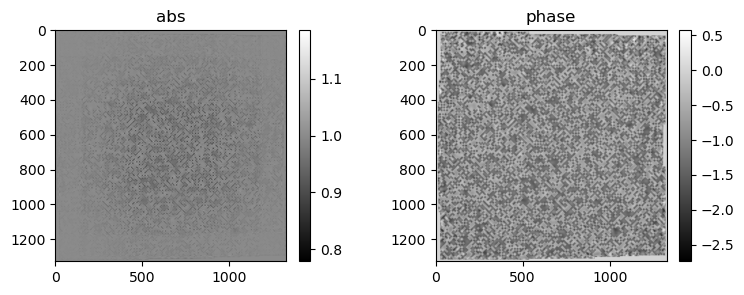

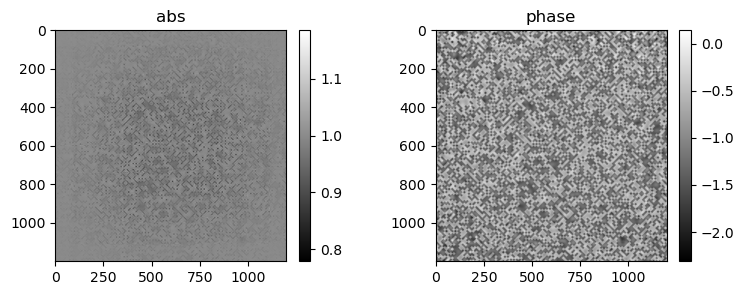

1) gammah=array(0.06143962, dtype=float32), err=1.02774e+04
2) gammah=array(0.07312579, dtype=float32), err=6.76223e+03
3) gammah=array(0.07838184, dtype=float32), err=4.92890e+03
4) gammah=array(0.08336867, dtype=float32), err=3.73160e+03
5) gammah=array(0.08138838, dtype=float32), err=2.94577e+03
6) gammah=array(0.08022603, dtype=float32), err=2.40704e+03
7) gammah=array(0.08210378, dtype=float32), err=2.02349e+03
8) gammah=array(0.08528475, dtype=float32), err=1.73096e+03
9) gammah=array(0.09026332, dtype=float32), err=1.48076e+03
10) gammah=array(0.09092165, dtype=float32), err=1.26059e+03
11) gammah=array(0.08816155, dtype=float32), err=1.07351e+03
12) gammah=array(0.08717138, dtype=float32), err=9.20840e+02
13) gammah=array(0.08927, dtype=float32), err=7.89784e+02
14) gammah=array(0.08754893, dtype=float32), err=6.78301e+02
15) gammah=array(0.08659132, dtype=float32), err=5.86428e+02
16) gammah=array(0.08673703, dtype=float32), err=5.10614e+02
17) gammah=array(0.0868651, dtype=fl

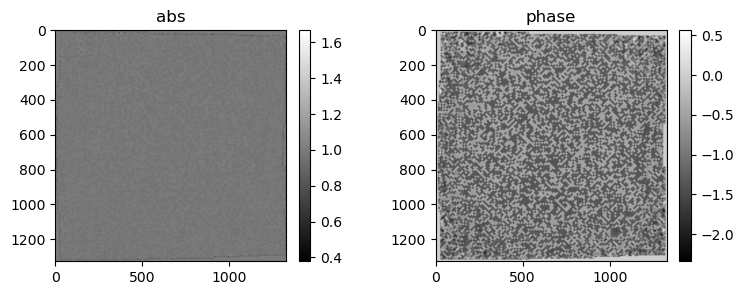

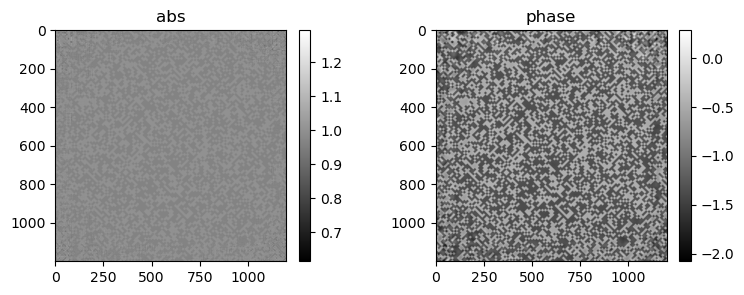

33) gammah=array(0.09249388, dtype=float32), err=1.08406e+02
34) gammah=array(0.09251398, dtype=float32), err=1.01032e+02
35) gammah=array(0.09226891, dtype=float32), err=9.43103e+01
36) gammah=array(0.09187856, dtype=float32), err=8.81932e+01
37) gammah=array(0.09117826, dtype=float32), err=8.26323e+01
38) gammah=array(0.09099777, dtype=float32), err=7.75483e+01
39) gammah=array(0.09107218, dtype=float32), err=7.28903e+01
40) gammah=array(0.09153904, dtype=float32), err=6.85996e+01
41) gammah=array(0.09219254, dtype=float32), err=6.46194e+01
42) gammah=array(0.09236542, dtype=float32), err=6.09166e+01
43) gammah=array(0.09308264, dtype=float32), err=5.74651e+01
44) gammah=array(0.09337591, dtype=float32), err=5.42475e+01
45) gammah=array(0.09425655, dtype=float32), err=5.12341e+01
46) gammah=array(0.09449803, dtype=float32), err=4.84110e+01
47) gammah=array(0.09449968, dtype=float32), err=4.57693e+01
48) gammah=array(0.09435432, dtype=float32), err=4.33036e+01
49) gammah=array(0.09397

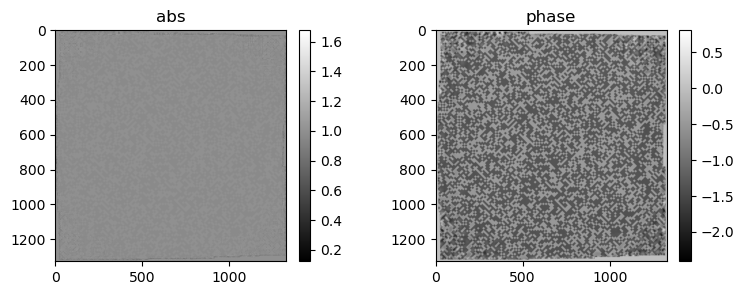

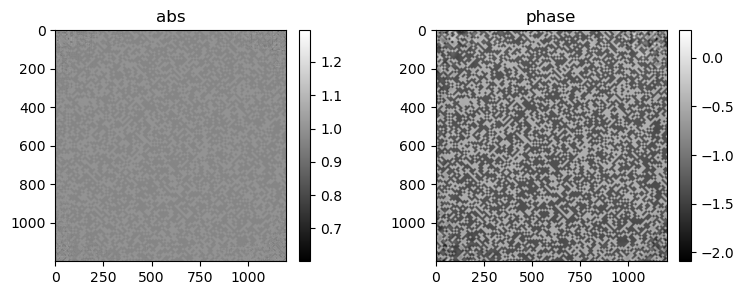

65) gammah=array(0.09368721, dtype=float32), err=1.92407e+01
66) gammah=array(0.09374201, dtype=float32), err=1.84533e+01
67) gammah=array(0.09390305, dtype=float32), err=1.77065e+01
68) gammah=array(0.09394626, dtype=float32), err=1.69992e+01
69) gammah=array(0.09392571, dtype=float32), err=1.63305e+01
70) gammah=array(0.09369616, dtype=float32), err=1.56998e+01
71) gammah=array(0.0934889, dtype=float32), err=1.51046e+01
72) gammah=array(0.0935364, dtype=float32), err=1.45425e+01
73) gammah=array(0.0937192, dtype=float32), err=1.40106e+01
74) gammah=array(0.09428141, dtype=float32), err=1.35054e+01
75) gammah=array(0.09444761, dtype=float32), err=1.30281e+01
76) gammah=array(0.09478766, dtype=float32), err=1.25774e+01
77) gammah=array(0.09463602, dtype=float32), err=1.21519e+01
78) gammah=array(0.09437596, dtype=float32), err=1.17491e+01
79) gammah=array(0.09388104, dtype=float32), err=1.13675e+01
80) gammah=array(0.09332152, dtype=float32), err=1.10054e+01
81) gammah=array(0.09285951

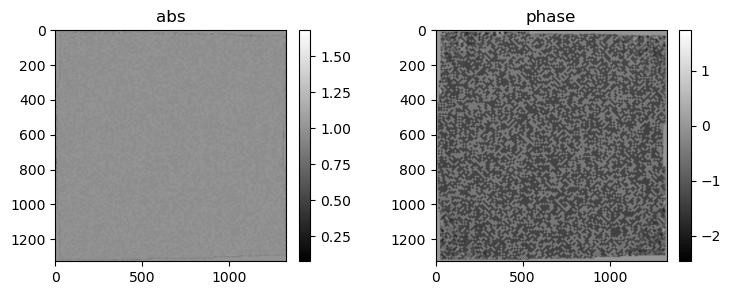

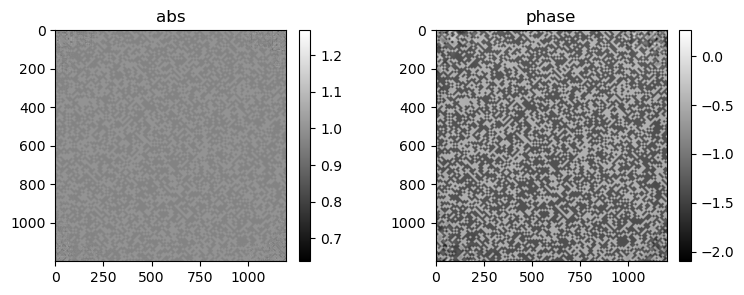

97) gammah=array(0.09433325, dtype=float32), err=6.75516e+00
98) gammah=array(0.09341398, dtype=float32), err=6.58734e+00
99) gammah=array(0.09277966, dtype=float32), err=6.42710e+00
100) gammah=array(0.09293389, dtype=float32), err=6.27296e+00
101) gammah=array(0.09328384, dtype=float32), err=6.12430e+00
102) gammah=array(0.09342612, dtype=float32), err=5.98130e+00
103) gammah=array(0.09395656, dtype=float32), err=5.84357e+00
104) gammah=array(0.09435231, dtype=float32), err=5.71099e+00
105) gammah=array(0.09468956, dtype=float32), err=5.58296e+00
106) gammah=array(0.09453501, dtype=float32), err=5.45979e+00
107) gammah=array(0.09457476, dtype=float32), err=5.34113e+00
108) gammah=array(0.09490752, dtype=float32), err=5.22655e+00
109) gammah=array(0.09489463, dtype=float32), err=5.11623e+00
110) gammah=array(0.09516267, dtype=float32), err=5.00963e+00
111) gammah=array(0.09469274, dtype=float32), err=4.90675e+00
112) gammah=array(0.0945057, dtype=float32), err=4.80730e+00
113) gammah=

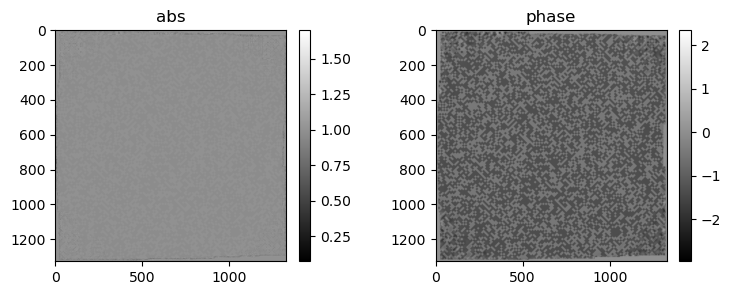

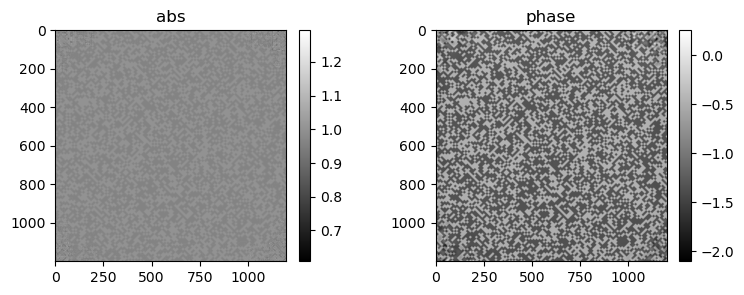

129) gammah=array(0.09404037, dtype=float32), err=3.50244e+00
130) gammah=array(0.09359398, dtype=float32), err=3.44457e+00
131) gammah=array(0.09363876, dtype=float32), err=3.38816e+00
132) gammah=array(0.09394222, dtype=float32), err=3.33311e+00
133) gammah=array(0.09452832, dtype=float32), err=3.27941e+00
134) gammah=array(0.09520457, dtype=float32), err=3.22682e+00
135) gammah=array(0.09556744, dtype=float32), err=3.17550e+00
136) gammah=array(0.09582512, dtype=float32), err=3.12539e+00
137) gammah=array(0.09605835, dtype=float32), err=3.07657e+00
138) gammah=array(0.09617774, dtype=float32), err=3.02896e+00
139) gammah=array(0.09612864, dtype=float32), err=2.98249e+00
140) gammah=array(0.09601666, dtype=float32), err=2.93727e+00
141) gammah=array(0.09617154, dtype=float32), err=2.89307e+00
142) gammah=array(0.09626429, dtype=float32), err=2.84992e+00
143) gammah=array(0.09634501, dtype=float32), err=2.80780e+00
144) gammah=array(0.09631693, dtype=float32), err=2.76663e+00
145) gam

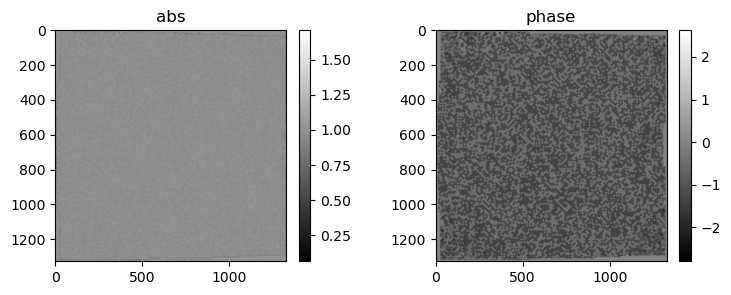

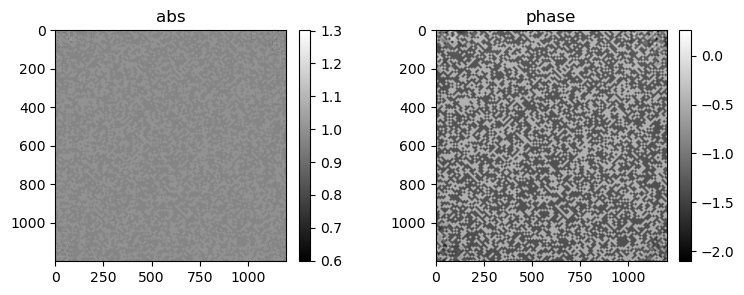

161) gammah=array(0.09515879, dtype=float32), err=2.19652e+00
162) gammah=array(0.09495702, dtype=float32), err=2.16978e+00
163) gammah=array(0.09504368, dtype=float32), err=2.14361e+00
164) gammah=array(0.09504836, dtype=float32), err=2.11798e+00
165) gammah=array(0.09518725, dtype=float32), err=2.09288e+00
166) gammah=array(0.09533652, dtype=float32), err=2.06830e+00
167) gammah=array(0.0952794, dtype=float32), err=2.04413e+00
168) gammah=array(0.09491865, dtype=float32), err=2.02041e+00
169) gammah=array(0.09486397, dtype=float32), err=1.99709e+00
170) gammah=array(0.0949304, dtype=float32), err=1.97410e+00
171) gammah=array(0.09478515, dtype=float32), err=1.95149e+00
172) gammah=array(0.0944616, dtype=float32), err=1.92928e+00
173) gammah=array(0.09453631, dtype=float32), err=1.90745e+00
174) gammah=array(0.09470885, dtype=float32), err=1.88593e+00
175) gammah=array(0.0953266, dtype=float32), err=1.86472e+00
176) gammah=array(0.09555145, dtype=float32), err=1.84393e+00
177) gammah=

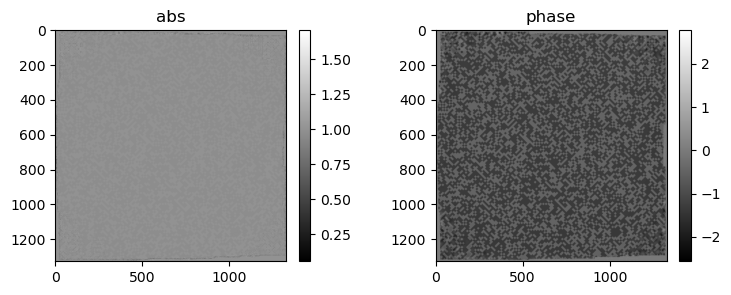

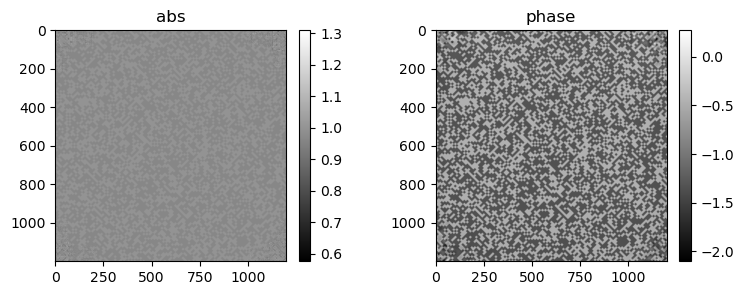

193) gammah=array(0.09500511, dtype=float32), err=1.54842e+00
194) gammah=array(0.09577344, dtype=float32), err=1.53340e+00
195) gammah=array(0.09596746, dtype=float32), err=1.51861e+00
196) gammah=array(0.09633301, dtype=float32), err=1.50404e+00
197) gammah=array(0.09681071, dtype=float32), err=1.48966e+00
198) gammah=array(0.09735992, dtype=float32), err=1.47548e+00
199) gammah=array(0.0973482, dtype=float32), err=1.46152e+00
200) gammah=array(0.09691496, dtype=float32), err=1.44785e+00
201) gammah=array(0.09634449, dtype=float32), err=1.43445e+00
202) gammah=array(0.09533302, dtype=float32), err=1.42135e+00
203) gammah=array(0.09484451, dtype=float32), err=1.40850e+00
204) gammah=array(0.09453883, dtype=float32), err=1.39589e+00
205) gammah=array(0.09490748, dtype=float32), err=1.38349e+00
206) gammah=array(0.09535958, dtype=float32), err=1.37127e+00
207) gammah=array(0.09534488, dtype=float32), err=1.35925e+00
208) gammah=array(0.0955011, dtype=float32), err=1.34744e+00
209) gamma

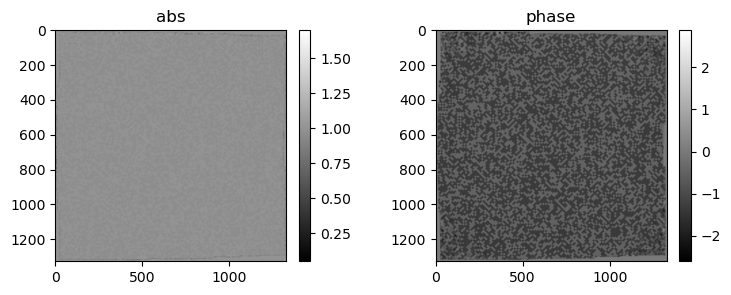

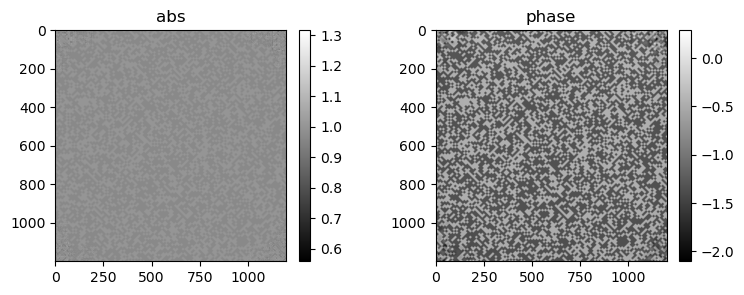

225) gammah=array(0.09724651, dtype=float32), err=1.17284e+00
226) gammah=array(0.09721299, dtype=float32), err=1.16388e+00
227) gammah=array(0.09700835, dtype=float32), err=1.15507e+00
228) gammah=array(0.09680802, dtype=float32), err=1.14639e+00
229) gammah=array(0.09687382, dtype=float32), err=1.13784e+00
230) gammah=array(0.09710597, dtype=float32), err=1.12939e+00
231) gammah=array(0.09695695, dtype=float32), err=1.12105e+00
232) gammah=array(0.09664205, dtype=float32), err=1.11282e+00
233) gammah=array(0.09592262, dtype=float32), err=1.10471e+00
234) gammah=array(0.09470867, dtype=float32), err=1.09677e+00
235) gammah=array(0.09387113, dtype=float32), err=1.08894e+00
236) gammah=array(0.09363678, dtype=float32), err=1.08121e+00
237) gammah=array(0.09428784, dtype=float32), err=1.07354e+00
238) gammah=array(0.09534194, dtype=float32), err=1.06594e+00
239) gammah=array(0.09581976, dtype=float32), err=1.05842e+00
240) gammah=array(0.09589636, dtype=float32), err=1.05104e+00
241) gam

In [12]:
import time
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma

 

def cg_holo(data,ref, init_psi,init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fpsi):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        return f

    data = np.sqrt(data)
    ref = np.sqrt(ref)
    psi = init_psi.copy()
    prb = init_prb.copy()

    conv = np.zeros(pars['niter'])
    gammaha = np.zeros(pars['niter'])
    gammah = 0       
        
    for i in range(pars['niter']):                                        
        
        gradpsi = gradient(psi,prb, data)
        
        
        if i==0:
            etapsi = -gradpsi
        else:
            # top
            h2u = hessian2(psi,gradpsi,etapsi,data,prb)
            # bottom
            h2b = hessian2(psi,etapsi,etapsi,data,prb)            
            beta = h2u/h2b            
            etapsi = -gradpsi + beta*etapsi
            
        h2u = -cp.sum(cp.real(gradpsi*cp.conj(etapsi)))
        h2b = hessian2(psi,etapsi,etapsi,data,prb)                    
        gammah = h2u/h2b 
        
        # npp = 17
        # errt = np.zeros(npp)
        # errt2 = np.zeros(npp)
        # if i>-1:
        #     for k in range(0,npp):
        #         psit = psi+(gammah*k/(npp-1))*etapsi
        #         fpsit = Lop(Sop(psit)*prb)+Lop2(prb)                
        #         errt[k] = minf(fpsit)    
        #     t = gammah*cp.arange(npp)/(npp-1)
        #     errt2 = minf(Lop(Sop(psi)*prb)+Lop2(prb))-h2u*t+0.5*h2b*t**2
        #     plt.plot(gammah.get()*np.arange(17)/16,errt,'.')
        #     plt.plot(gammah.get()*np.arange(17)/16,errt2.get(),'.')
        #     # plt.plot(gammah.get()*np.arange(npp)/(npp-1),errt-errt2.get(),'.')
        #     plt.show()

       
#        print(f'{h2b=}, {gammah=}, {cp.linalg.norm(gradpsi)=}')
        psi += gammah*etapsi
        
        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi)*prb)+Lop2(prb)
            err = minf(fpsi)
            conv[i] = err
            gammaha[i] = gammah
            print(f'{i}) {gammah=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_polar(psi[0]+1,show)
            mshow_polar(psi[0,pad:-pad,pad:-pad]+1,show)
        
    return psi,prb,conv,gammaha

# fully on gpu
rec_psi = recMultiPaganin.copy()-1
data = cp.array(data00.copy())
ref = cp.array(ref0.copy())

rec_prb = cp.array(np.load(f'{path}/data/prb_{flg}.npy'))
pars = {'niter': 256, 'err_step': 1, 'vis_step': 32}
# mshow_polar(rec_psi[0],show)
rec_psi,rec_prb,conv,gammaha = cg_holo(data,ref,rec_psi,rec_prb, pars)
# k = f'cghessians'
# np.save(f'data/rec_psi_{k}_{pars['niter']}',rec_psi.get())
# np.save(f'data/rec_prb_{k}_{pars['niter']}',rec_prb.get())
# np.save(f'data/conv_{k}_{pars['niter']}',conv)
# np.save(f'data/gammaha_{k}_{pars['niter']}',gammaha)



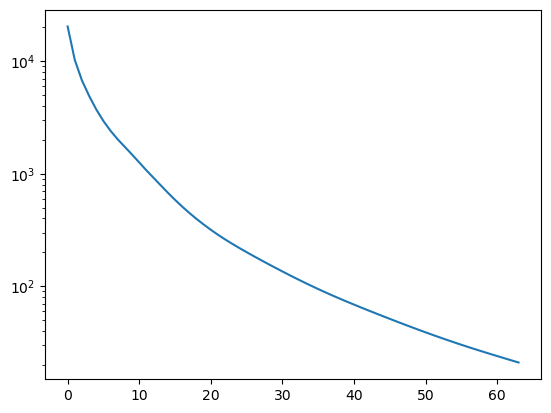

In [10]:
a = n

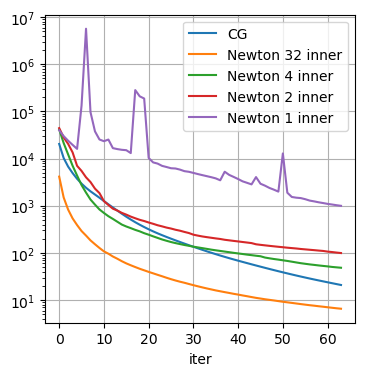

In [38]:
conv64_32 = np.load('conv64_32.npy')
conv64_4 = np.load('conv64_4.npy')
conv64_2 = np.load('conv64_2.npy')
conv64_1 = np.load('conv64_1.npy')

plt.figure(figsize=(4,4))
plt.plot(conv[:64],label='CG')
plt.plot(conv64_32,label='Newton 32 inner')
plt.plot(conv64_4,label='Newton 4 inner')
plt.plot(conv64_2,label='Newton 2 inner')
plt.plot(conv64_1,label='Newton 1 inner')
plt.xlabel('iter')
plt.legend()
plt.grid('on')
plt.yscale('log')

